[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dominik-strutz/moon_oed/blob/main/00_c_raytracer.ipynb)

In [1]:
# MAKE SURE TO RUN THIS CELL FIRST
# this might take a minute or two
# This cell will install the necessary dependencies and import the necessary modules for the notebook to run in Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
    
if IN_COLAB:
    dependencies_installed = False

    if not dependencies_installed:
        ! rm -rf *
        ! git clone --quiet https://github.com/dominik-strutz/moon_oed tmp
        ! mv tmp/* .
        ! rm -rf tmp
        # only install the first 8 lines of the requirements file to only install the necessary dependencies
        # ! head -3 requirements.txt > tmp.txt
        # ! mv tmp.txt requirements.txt 
        # ! pip install -q -r requirements.txt
        dependencies_installed = True
    from google.colab import output
    output.enable_custom_widget_manager()

In [2]:
import math
import torch

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('https://raw.githubusercontent.com/dominik-strutz/dotfiles/main/mystyle.mplstyle')

from helpers.forward import integrate_multiple_gaussians

In [5]:
import torch
import numpy as np

# Seed for reproducibility
torch.manual_seed(6)

# Generate 10 Gaussians with random positions and scales
num_gaussians = 10
box_size = 400
gaussian_mean = torch.rand(num_gaussians, 2) * box_size  # Centered in the box
gaussian_std = torch.rand(num_gaussians, 2) * 50 + 10  # Random scales (1 to 6)
gaussian_theta = torch.rand(num_gaussians) * 2 * np.pi  # Random rotations
gaussian_amp = torch.rand(num_gaussians) * 10 + 350  # Random amplitudes (1 to 3)

# Define ray start and directions
ray_start = torch.tensor([box_size / 6, box_size / 6])  # Point on the right side of the box
max_length = box_size  # Maximum length of the rays
num_angles = 360
num_lengths = 200

angles = torch.linspace(0, 2 * np.pi, num_angles)
ray_lengths = torch.linspace(0, max_length, num_lengths).unsqueeze(1)  # Lengths to integrate

# Generate ray directions for each angle
ray_directions = torch.stack([torch.cos(angles), torch.sin(angles)], dim=-1)  # Directions in XY-plane

# Create meshgrid of rays for all lengths
ray_directions = ray_directions.unsqueeze(1).repeat(1, num_lengths, 1)  # (num_angles, num_lengths, 2)
ray_lengths_mesh = ray_lengths.repeat(1, num_angles).T.unsqueeze(-1)  # (num_angles, num_lengths, 1)
rays = ray_directions * ray_lengths_mesh  # Multiply directions by lengths

# Calculate ray endpoints
ray_endpoints = ray_start.unsqueeze(0).unsqueeze(0) + rays  # (num_angles, num_lengths, 2)

# Flatten start and endpoints for integration
ray_start_flat = ray_start.unsqueeze(0).repeat(num_angles * num_lengths, 1)
ray_end_flat = ray_endpoints.reshape(-1, 2)

print(gaussian_mean.shape)

# Integrate using the new function
integrated_values = integrate_multiple_gaussians(
    ray_start=ray_start_flat,
    ray_end=ray_end_flat,
    gaussian_mean=gaussian_mean,
    gaussian_std=gaussian_std,
    gaussian_amp=gaussian_amp,
    gaussian_theta=gaussian_theta,  
).reshape(num_gaussians, num_angles, num_lengths).sum(0).numpy()

torch.Size([10, 2])


In [6]:
from helpers.plotting import gaussian_2d

x = torch.linspace(0, box_size, 100)
y = torch.linspace(0, box_size, 100)

X, Y = torch.meshgrid(x, y, indexing='ij')

X = X.flatten()
Y = Y.flatten()

average_posterior = gaussian_2d(
    X.unsqueeze(-1), Y.unsqueeze(-1),
    gaussian_mean,
    gaussian_std,
    gaussian_amp,
    gaussian_theta).reshape(len(x), len(y), num_gaussians).mean(dim=-1)

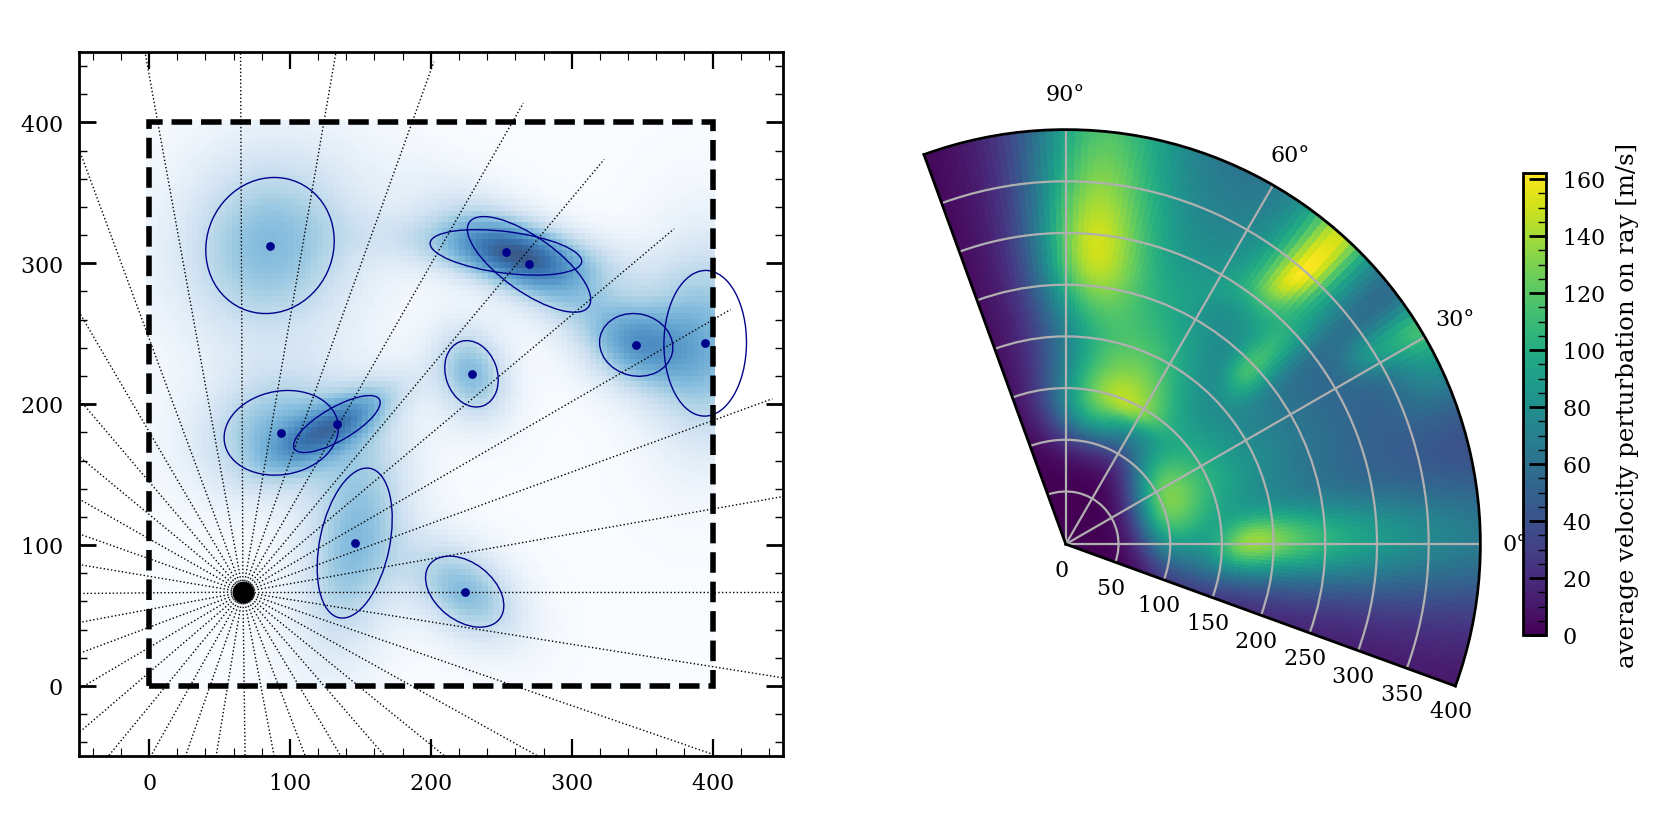

In [7]:
from helpers.plotting import plot_ellipses
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=200,)

ax1.pcolormesh(x, y, average_posterior.T, cmap='Blues', shading='auto', zorder=-2, alpha=0.8)

plot_ellipses(ax1, gaussian_mean, gaussian_std, gaussian_theta, gaussian_amp,
              scatter_kwargs={'c': 'darkblue', 's': 10},
              ellipse_kwargs={'edgecolor': 'darkblue', 'linewidth': 0.5})

ax1.scatter(ray_start[0], ray_start[1], color='black', s=50)  # Plot the ray start
# draw rays (only maximum length) in light gray
for i in range(0, num_angles, 10):
    ax1.plot([ray_start[0], ray_start[0] + max_length * torch.cos(angles[i])],
            [ray_start[1], ray_start[1] + max_length * torch.sin(angles[i])],
            color='k', zorder=-1, linewidth=0.5, linestyle=':')

buffer=50
ax1.set_xlim(0-buffer, box_size+buffer)
ax1.set_ylim(0-buffer, box_size+buffer)
# draw rectangle
ax1.add_patch(plt.Rectangle(
    (0, 0), box_size, box_size,
    fill=None, linestyle='dashed', color='black', linewidth=2))
ax1.set_aspect('equal')

# turn off ax2
ax2.axis('off')
# set projection
ax2 = plt.subplot(122, projection='polar')

# Plot the integrated values as a colormesh in the second subplot
r, theta = np.meshgrid(
    ray_lengths.numpy().flatten(),
    angles.numpy())
c = ax2.pcolormesh(theta, r, integrated_values, shading='auto')

# only plot top right quadrant
ax2.set_thetamin(-20)
ax2.set_thetamax(110)
ax2.set_rmax(max_length)

# Add a color bar
fig.colorbar(c, ax=ax2, label='average velocity perturbation on ray [m/s]', shrink=0.6)

plt.show()